<a href="https://colab.research.google.com/github/paulo-batista/LABDATA-FIA/blob/main/aula16_parte1_clusteriza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Autores**: Prof. João Nogueira e Prof. Dino Magri

**Contato**: `joaonogueira@fisica.ufc.br` e `professor.dinomagri@gmail.com`

**Licença deste notebook**: 
<br>
<img align="left" width="80" src="https://licensebuttons.net/l/by/3.0/88x31.png" />

<br>
<br>

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)


---

# Criando os dados

Antes de criarmos os dados, iremos utilizar uma biblioteca que irá facilitar a criação dos gráficos de ML. Essa biblioteca estende as funcionalidades da API do Scikit-Learn. 

A biblioteca é a `yellowbrick`

Link projeto: https://www.scikit-yb.org/en/latest/

Após a instalação, será necessário reiniciar o ambiente de execução do Colab.

In [42]:
!pip install yellowbrick
!pip install -U yellowbrick

In [16]:
!pip install -U scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

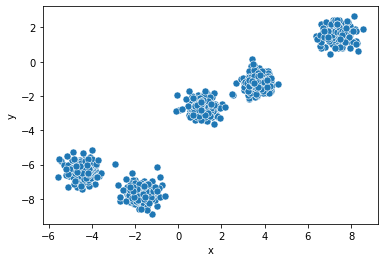

In [4]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=800, centers=5, cluster_std=0.40, random_state=25)
X = pd.DataFrame(X, columns=['x', 'y'])

sns.scatterplot(data=X, x='x', y='y', s=50, palette='deep');

# Algoritmos

## KMeans

In [7]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

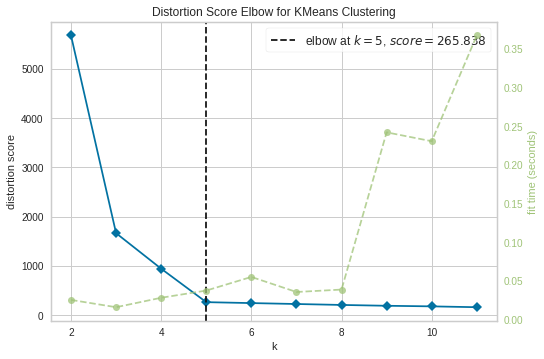

In [8]:
# Usando o método do cotovelo, também conhecido como Elbow Method

# A classe KElbowVisualizer implementa o método "elbow" para selecionar o número ótimo de clusters para o KMeans.


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X);
visualizer.show();

O resultado obtido pelo método "Elbow" (linha azul ou contínua) mostra que a quantidade ideal de cluster é igual a 5.

Esse gráfico também é importante pois mostra o tempo em segundos (linha verde ou tracejada) que demorou para realizar os calculos para cada `k`.


Um vez que temos o número ideal de clusters podemos utilizar a métrica da Silhueta para avaliar os grupos gerados.

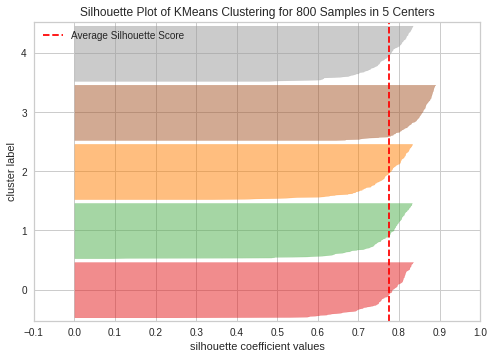

In [9]:
# Visualizando a métrica da Silhueta
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(n_clusters=5, random_state=42)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)
visualizer.show();

A linha vermelha tracejada vertical é a pontuação média. Um modo de interpretar isso é garantir que cada cluster se destaque acima da média, e as pontuações dos clusters sejam razoáveis.

Vamos testar com 4, 5, 6 e 7 clusters para avaliar a visualização da métrica da silhueta.


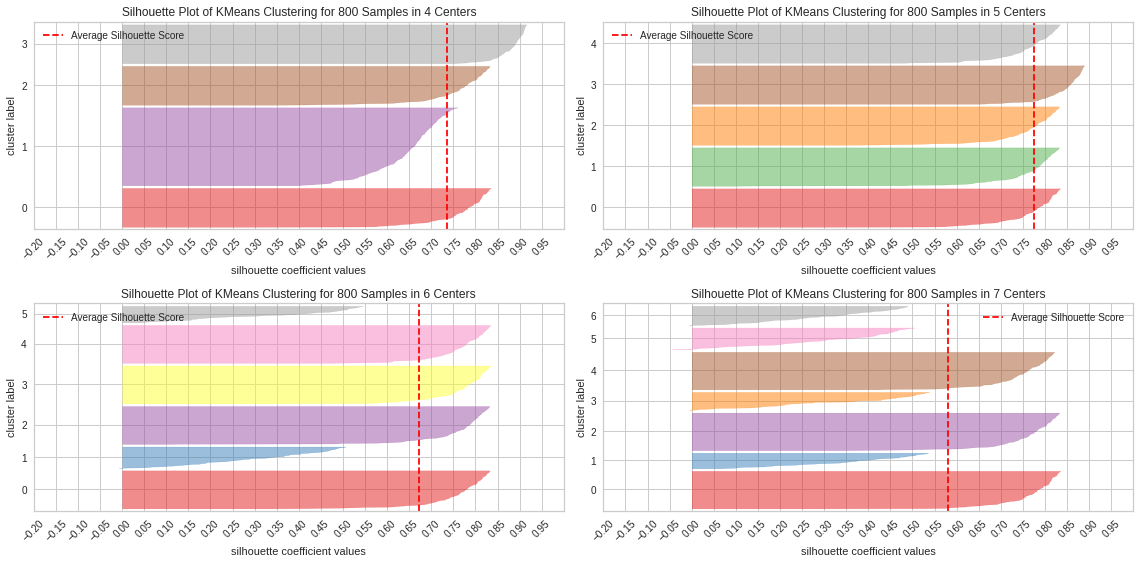

In [10]:

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.reshape(4)

# range(4, 8) irá gerar os valores 4, 5, 6 e 7 que queremos testar.
for i, k in enumerate(range(4, 8)):
    ax = axes[i]
    model = KMeans(n_clusters=k, random_state=42)
    sil_viz = SilhouetteVisualizer(model, ax=ax)
    sil_viz.fit(X)
    sil_viz.finalize()
    ax.set_xlim(-0.2, 1)
    ax.set_xticks(np.arange(-0.2, 1, 0.05))
    ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

Podemos concluir que:

* Para **os ajustes com 6 e 7 clusters** (imagem inferior esquerda e direita) tiveram valores da métrica que não destacaram acima da média para alguns grupos.
* Para o **ajuste com 4 clusters** (imagem superior esquerda) ambos os grupos superam a média, porém o grupo 0 superou a média em apenas alguns pontos, porém não conseguiu se destacar como o grupo 1.
* Por fim, no **ajuste com 5 clusters**, TODOS os grupos gerados se destacaram acima da média.

In [11]:
kmeans = KMeans(n_clusters=5, random_state=30)
kmeans.fit(X)
labels = kmeans.predict(X)

In [12]:
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

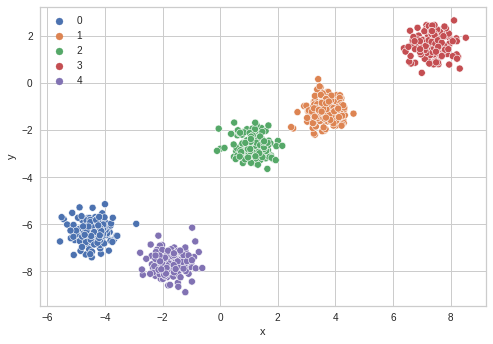

In [13]:
# O parâmetro `hue` adiciona as cores distintas com base no parâmetro `palette`.
sns.scatterplot(data=X, x='x', y='y', hue=labels, s=50, palette='deep');

Assim, podemos concluir que o KMeans com 5 clusters conseguiu realizar a separação corretamente.

## Cluster Hierárquico

Esse método, também conhecido como Cluster Aglomerativo, começa com cada amostra em seu próprio cluster. Em seguida, combina os clusters "mais próximos". Esse processo irá repetir enquanto se mantém o controle dos tamanhos mais próximos.

Após terminar esse processo, será criado um dendrograma, que nada mais é do que uma árvore que controla quando os clusters foram criados e qual é a métrica das distâncias.

Assim, será possível visualizar os clusters (de 1 até a quantidade de dados).

As alturas representam o nível de semelhança dos clusters, quando são unidos. Para descobrir quantos clusters existem nos dados, podemos "passar" uma linha horizontal no ponto em que ele cruzaria as linhas mais altas.

In [14]:
from sklearn.cluster import AgglomerativeClustering # cluster hierárquico

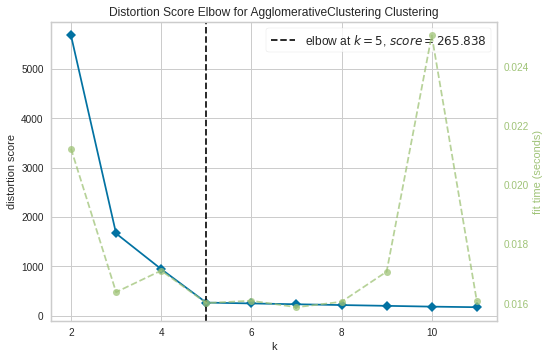

In [15]:
# método cotovelo
hclust = AgglomerativeClustering(n_clusters=5)
visualizer = KElbowVisualizer(hclust, k=(2,12))

visualizer.fit(X)        
visualizer.show();  

A classe `SilhoutteVisualizer` não implementa o método `predict` que será necessário para realizar o calculo da silhueta, desta forma, podemos utilizar a biblioteca `scipy` para visualizar o dendograma.


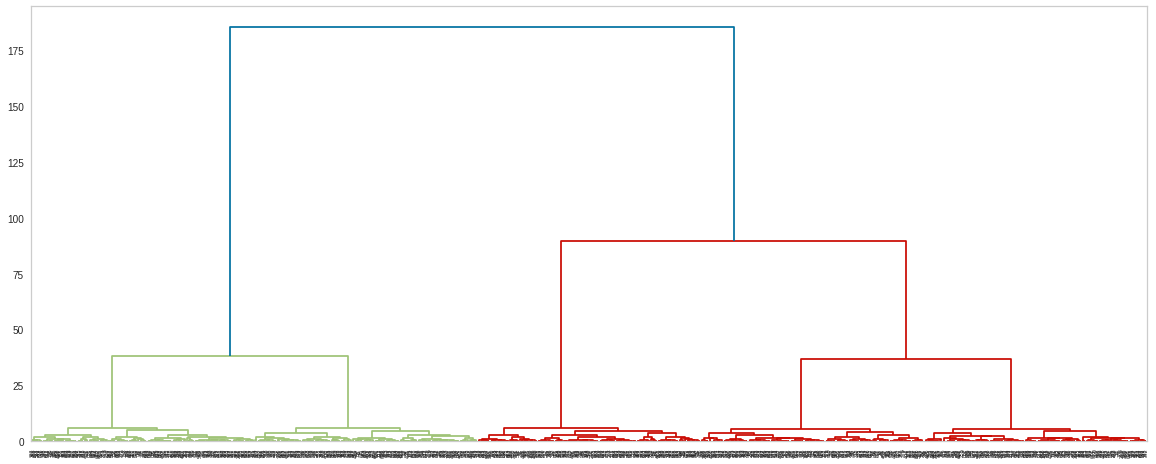

In [16]:
from scipy.cluster import hierarchy

fig, ax = plt.subplots(figsize=(20, 8))
ax.grid(False)

# Outros métodos podem ser visualizados em https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
cluster_aglo = hierarchy.linkage(X, method='ward') # O método `ward` utiliza um algoritmo que minimiza a variancia.

dend = hierarchy.dendrogram(cluster_aglo)

Assim, conseguimos visualizar quantos clusters serão necessários, e então podemos criar um modelo com o Sklearn.

In [17]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=5, linkage='ward')
ag.fit(X)

AgglomerativeClustering(n_clusters=5)

O algoritmo `AgglomerativeClustering` não tem um método predict, por isso o método `SilhouetteVisualizer` do yellowbrick não funciona.

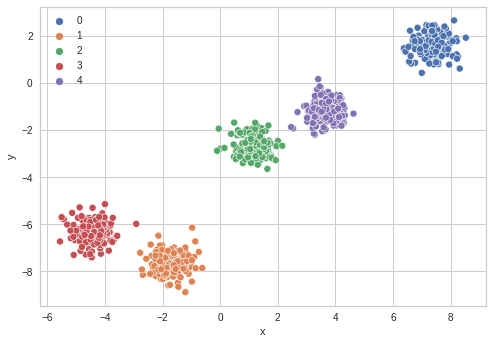

In [18]:
sns.scatterplot(data=X, x='x', y='y', hue=ag.labels_, s=50, palette='deep');

## DBSCAN
<br></br>

---
**ATENÇÃO**: Verifique os slides da aula para entendimento do funcionamento do algoritmo DBSCAN.

---

<br></br>
Antes de entender como o algoritmo DBSCAN funciona, precisamos entender de maneira geral como funcionam os algoritmos de clusterização baseados em densidade.

Os algoritmos de clusterização baseada em densidade identificam os clusters distintos no conjunto de dados com a ideia de que um cluster no espaço de dados é uma região adjacente de alta densidade de pontos, separada de outros clustres por regiões adjacentes de baixa densidade de pontos.

Vamos criar alguns dados para ilustrar esse ponto.

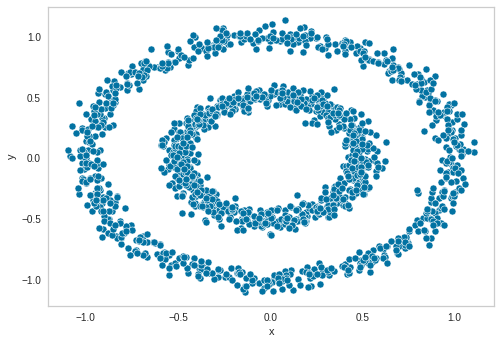

In [19]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1500, factor=.5,
                                      noise=.05)
X = pd.DataFrame(X, columns=['x', 'y'])
sns.set_style({'axes.grid' : False})
sns.scatterplot(data=X, x='x', y='y', s=50, palette='deep');

Como podemos visualizar existem diversos pontos adjacentes que contém alta densidade de pontos (circulo interno e externo), sendo separado por regiões adjacentes de baixa densidade de pontos.

Desta forma, o DBSCAN pode descobrir clusters com diferentes formas e tamanhos em uma grande quantidade de dados, inclusive dados que contém ruído.

O algoritmo **DBSCAN** (*Density-Based Spatial Clustering of Applications with Noise*) utiiza 2 principais parâmetros:

* `minPts` que é o número mínimo de pontos (um limiar) que deverá permanecer juntos em uma determinada região considerada densa.
* `eps` que é a medida da distância que será utilizada para localizar os pontos vizinhos de cada ponto.




In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(200, noise=.05, random_state=0)
X = pd.DataFrame(X, columns=['x', 'y'])

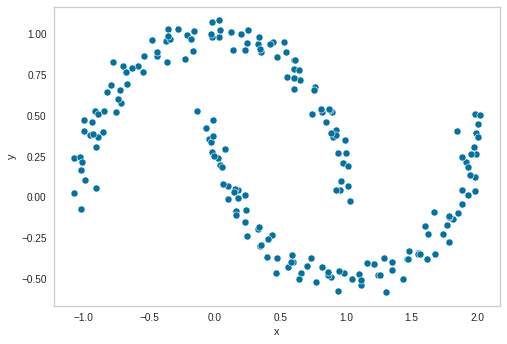

In [21]:
sns.scatterplot(data=X, x='x', y='y', s=50, palette='deep');

Para esse tipo de dado em que as fronteiras não são linearmente separáveis, o KMeans não é uma boa escolha. Vejamos como o KMeans encontraria os dois clusters:

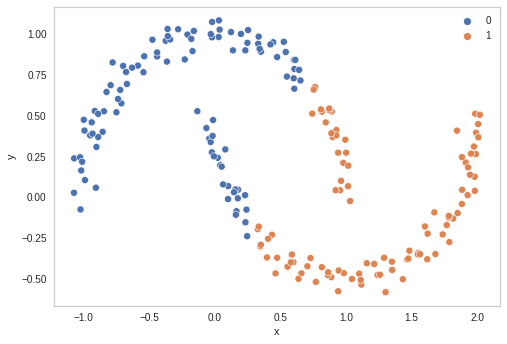

In [22]:
labels = KMeans(n_clusters=2).fit_predict(X)
sns.scatterplot(data=X, x='x', y='y', hue=labels, s=50, palette='deep');

O KMeans não detecta de forma correta os dois clusters. Vamos ver se o Cluster Hierárquico obtém um resultado melhor:

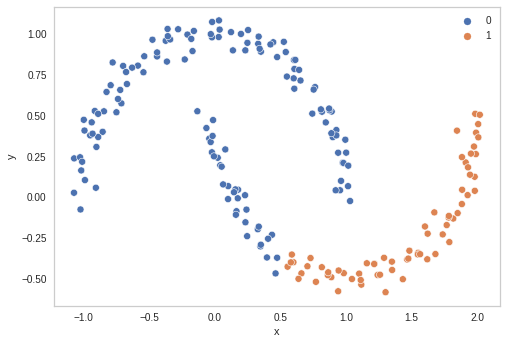

In [23]:
hclust = AgglomerativeClustering(n_clusters=2).fit(X)
sns.scatterplot(data=X, x='x', y='y', hue=hclust.labels_, s=50, palette='deep');

O Cluster Hierárquico também não faz um bom trabalho. Fica claro que temos que a densidade dos pontos aqui é extremamente importante e deve ser levada em conta. O principal algoritmo que considera a densidade dos pontos na hora de realizar o agrupamento é o `DBSCAN`.

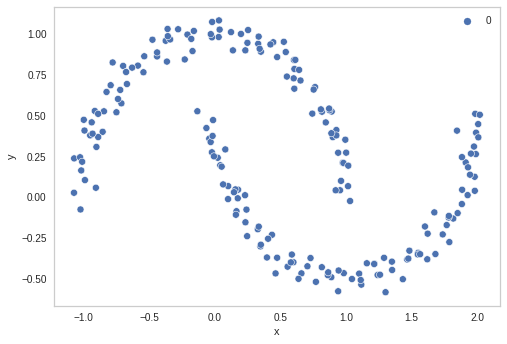

In [24]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
dbscan.fit(X)
sns.scatterplot(data=X, x='x', y='y', hue=dbscan.labels_, s=50, palette='deep');

O tamanho de raio default `eps` usado pelo DBSCAN é de `0.5`. Por isso que o algoritmo não encontrou clusters. Vamos diminuir esse valor para `0.2`.

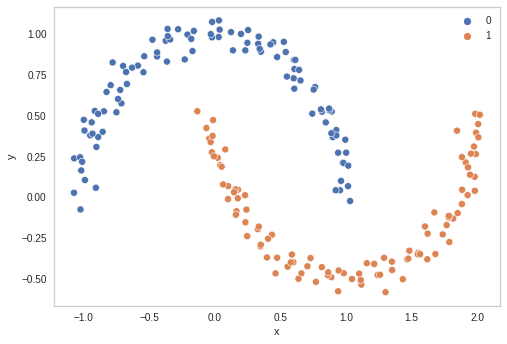

In [25]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)
sns.scatterplot(data=X, x='x', y='y', hue=dbscan.labels_, s=50, palette='deep');

Agora ele conseguiu encontrar automaticamente os dois clusters existentes. Apenas para título de curiosidade, o que acontece se diminuirmos mais ainda o valor de `eps`? Provavelmente ele irá encontrar pontos sem clusters, que receberá o valor `-1` indicando que esse ponto é um outlier (de acordo com o `DBSCAN`).

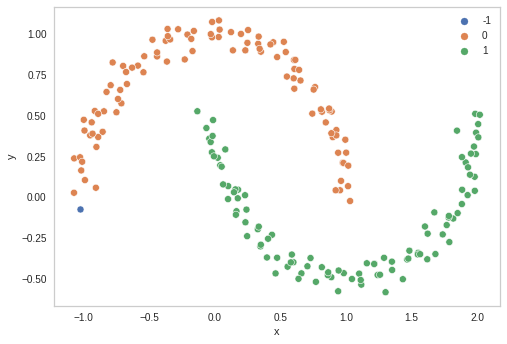

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15)
dbscan.fit(X)
sns.scatterplot(data=X, x='x', y='y', hue=dbscan.labels_, s=50, palette='deep');

Com `eps=0.15`, o `DBSCAN` encontrou um ponto outlier.

### Encontrando os melhores valores para `eps`.

In [27]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import numpy as np

In [28]:
vizinhos = NearestNeighbors(n_neighbors=2).fit(X) # Precisa ser 2, uma vez que queremos as distâncias entre dois pontos.
distancias, idxs = vizinhos.kneighbors(X)

In [29]:
distancias[:4]

array([[0.        , 0.01652737],
       [0.        , 0.06272955],
       [0.        , 0.02896776],
       [0.        , 0.11353429]])

In [30]:
idxs[:4]

array([[  0, 192],
       [  1, 168],
       [  2, 149],
       [  3, 171]])

In [31]:
# Agora iremos ordernar para plotar os resultados
distancias = np.sort(distancias, axis=0)

distancias[:4]

array([[0.        , 0.00268113],
       [0.        , 0.00268113],
       [0.        , 0.00602625],
       [0.        , 0.00602625]])

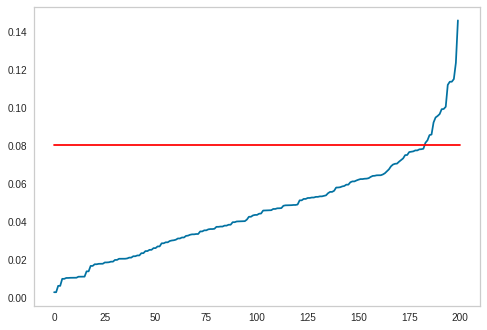

In [32]:
plt.plot(distancias[:, 1])
plt.plot([0, 200], [0.08, 0.08], color='red'); # Valores capturados manualmente

# Métricas de avaliação de qualidade do ajuste

## Mapa de Calor

Mapa de Calor, ou heatmap, são importante para criar visualizações de valores agregadas das features por cluster. Também é uma ótima ferramenta de visualização quando nossa tabela possui muitas colunas (alta dimensionalidade).

In [33]:
dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)

DBSCAN(eps=0.2)

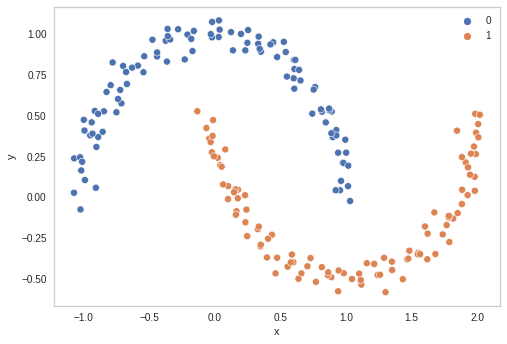

In [34]:
sns.scatterplot(data=X, x='x', y='y', hue=dbscan.labels_, s=50, palette='deep');

In [35]:
tabulacao = X.groupby(dbscan.labels_).mean()
tabulacao

,x,y
0,-0.005182,0.633201
1,0.998144,-0.128768


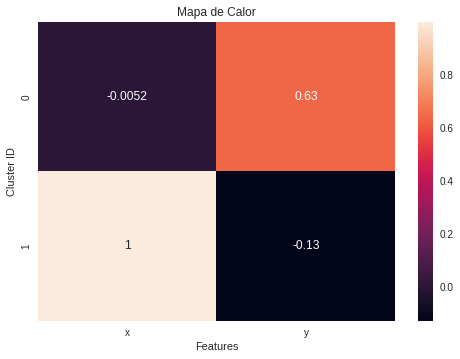

In [36]:
fig, ax = plt.subplots()

sns.heatmap(tabulacao, ax=ax, annot=True);
ax.set_title('Mapa de Calor');
ax.set_ylabel('Cluster ID');
ax.set_xlabel('Features');

Com o heatmap fica evidente que o cluster 1 tem um valor médio de `x` bem maior que o cluster 0. Como podemos visualizar no gráfico gerado anteriormente (Scatter Plot).

## Surrogate Tree


Com um modelo de cluster treinamento, é possível que a seguinte pergunta apareça: Quais seriam as variáveis mais importantes para definir os clusters?

O mapa de calor já deve ser capaz de auxiliar nesse processo, mas uma **Surrougate Tree** permite automaticamente selecionar as principais **features** (características).

A ideia desse método é treinar uma árvore de decisão com os clusters gerados e utiliza-los como *labels* na árvore de decisão e posteriormente, selecionar as *features* mais importantes geradas pelo modelo de árvore de decisão.


Vamos simular esse cenário, criando um conjunto de dados com 15 colunas (features) e 800 linhas.

In [37]:
X, y = make_blobs(n_samples=800, centers=10, n_features=15, center_box=(-100, 100), cluster_std=0.40, random_state=25)
X = pd.DataFrame(X, columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'])
X.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
0,-65.352705,57.411607,-94.177159,59.250322,38.515571,-0.968986,-82.728181,87.335037,-83.048417,-5.527122,60.968062,-83.101869,-51.673290,78.804634,-4.312503
1,-43.311208,80.180887,33.519749,-8.929151,-42.372939,5.285435,12.468289,48.552535,66.097482,63.874547,-84.395618,28.987730,-37.641425,4.218819,91.230668
2,-18.261360,-78.781166,-82.568332,49.625595,-62.276388,-97.348704,82.743861,85.618405,16.529422,-36.634566,99.505989,-69.895187,98.838944,-74.916388,-29.913263
3,6.282713,-35.793694,60.870781,91.908519,7.723352,0.347727,59.468484,59.326308,-75.548669,-50.902437,25.273475,-24.420320,-87.433298,-24.364240,-85.042048
4,6.118262,-35.609323,61.534510,92.110423,7.845672,-0.521216,60.376786,59.096048,-75.898694,-51.072708,24.955175,-24.377027,-87.016360,-25.567936,-85.262195


Note que temos mais do que 2 dimensões, logo visualizar esses pontos não é possível sem aplicar alguma técnica de redução de dimensionalidade (será visto na próxima aula).

In [ ]:
X.describe()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.677425,-8.509643,6.550411,-0.134856,13.322040,-35.211209,28.169700,29.292080,0.409463,-14.209278,-2.252118,-45.035847,-3.822535,-14.478258,-10.477571
std,50.185003,55.344073,55.720386,64.752832,43.174330,36.071078,49.508799,54.495652,56.128792,44.996729,59.197308,43.700843,61.871810,49.144244,53.786322
min,-65.837678,-79.004976,-94.177159,-83.089255,-64.190190,-97.658480,-83.011700,-85.934199,-83.993893,-96.885641,-95.525539,-94.006385,-99.598799,-78.363869,-86.089635
25%,-43.579521,-49.441218,-44.227406,-62.742147,-17.749862,-73.581216,3.229503,-12.413904,-40.797471,-49.556280,-55.688542,-81.132525,-51.134831,-67.234870,-60.660529
50%,-6.883492,-35.035874,37.102594,-18.030074,18.049329,-23.747184,45.268769,50.532768,10.437604,-16.131614,6.558185,-64.140591,3.791141,-20.533813,-14.909968
75%,54.992150,58.068551,52.490809,59.059757,52.381430,-1.598032,60.178371,82.607064,35.391392,20.402604,32.103451,-22.763078,43.958208,17.097057,13.443115
max,77.724914,80.787428,62.586834,93.163204,69.703580,6.415402,83.754494,88.347434,100.501188,65.405612,100.534410,32.084262,99.829994,79.379212,92.712361


Diferentemente dos exemplos acima, aqui precisamos fazer um `feature scaling`, pois temos variáveis em diferentes escalas.

In [38]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
0,0.003378,0.853711,0.000000,0.807589,0.767069,0.929047,0.001700,0.994191,0.005125,0.562929,0.798193,0.086482,0.240314,0.996358,0.457361
1,0.156910,0.996204,0.814581,0.420761,0.162944,0.989143,0.572538,0.771663,0.813525,0.990566,0.056768,0.975442,0.310674,0.523527,0.991713
2,0.331398,0.001401,0.074053,0.752982,0.014293,0.002976,0.993940,0.984341,0.544856,0.371253,0.994755,0.191221,0.995031,0.021855,0.314182
3,0.502362,0.270421,0.989053,0.992881,0.537094,0.941698,0.854371,0.833481,0.045775,0.283338,0.616133,0.551873,0.061002,0.342326,0.005859
4,0.501216,0.271575,0.993287,0.994027,0.538008,0.933349,0.859817,0.832160,0.043878,0.282288,0.614510,0.552217,0.063092,0.334696,0.004628


In [ ]:
X_scaled.describe()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.463318,0.441168,0.642543,0.470657,0.578908,0.600028,0.666690,0.661150,0.457483,0.509432,0.475739,0.388376,0.480253,0.404998,0.422882
std,0.349569,0.346350,0.355441,0.367387,0.322452,0.346591,0.296876,0.312687,0.304229,0.277259,0.301935,0.346583,0.310245,0.311546,0.300815
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.155041,0.185014,0.318630,0.115443,0.346845,0.231348,0.517138,0.421848,0.234133,0.291632,0.203188,0.102100,0.243014,0.070551,0.142219
50%,0.410651,0.275164,0.837436,0.369125,0.614215,0.710181,0.769223,0.783026,0.511837,0.497587,0.520676,0.236860,0.518430,0.366609,0.398092
75%,0.841653,0.857823,0.935597,0.806508,0.870628,0.923002,0.858628,0.967063,0.647092,0.722702,0.650969,0.565017,0.719841,0.605167,0.556665
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


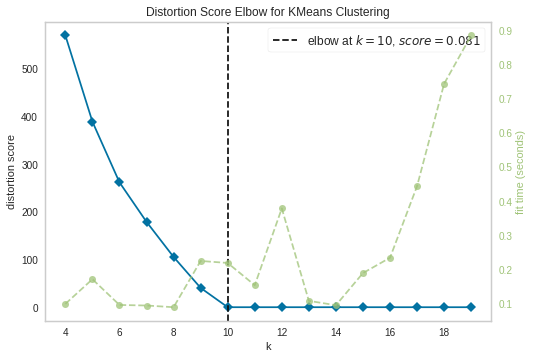

In [39]:
# Encontrando o número ideal de cluster de acordo com o algoritmo
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 20))

visualizer.fit(X_scaled)
visualizer.show();

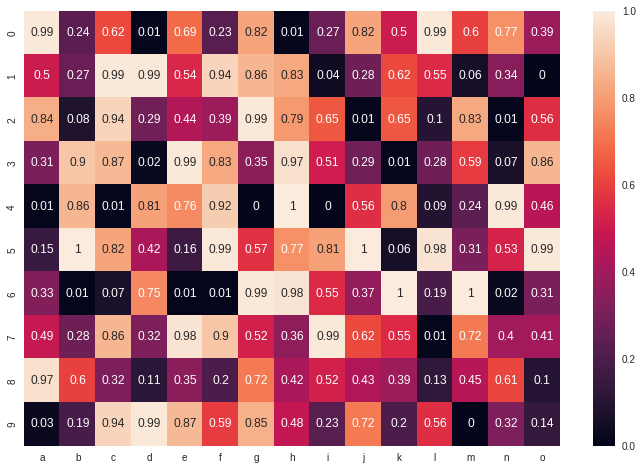

In [40]:
kmeans = KMeans(n_clusters=10, random_state=5)
kmeans.fit(X_scaled)

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(X_scaled.groupby(kmeans.labels_).mean().round(2), ax=ax, annot=True);

Esse heatmap já está bastante poluído e olhando de cara não conseguimos distinguir bem os principais clusters. Vamos rodar uma árvore de decisão e encontrar das 10 melhores features.

In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=30)
clf.fit(X_scaled, kmeans.labels_)

DecisionTreeClassifier(random_state=30)

In [ ]:
top_features = pd.Series(clf.feature_importances_, index=X_scaled.columns).sort_values(ascending=False).head(10).index.tolist()

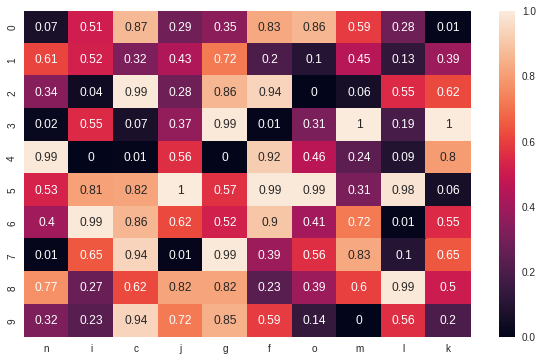

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(X_scaled.groupby(kmeans.labels_)[top_features].mean().round(2), ax=ax, annot=True);

Podemos visualizar que no Cluster 0, as **features** `c, f, o` são as principais caracteristicas dentro desse cluster.